### Reference

see [Unsupervised outlier detection in multidimensional data](https://journalofbigdata.springeropen.com/articles/10.1186/s40537-021-00469-z)

In [ ]:
import logging
import threading
import itertools
import json

import pandas as pd
from pandas.plotting import register_matplotlib_converters
import numpy as np  
import scipy as sp
import ruptures as rpt

from sklearn import cluster, datasets, mixture
from sklearn import ensemble
from sklearn import linear_model
from sklearn import metrics
from sklearn.covariance import MinCovDet
from sklearn.neighbors import (KernelDensity, NearestNeighbors, kneighbors_graph)
from sklearn.pipeline import Pipeline, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.mixture import BayesianGaussianMixture
from sklearn.preprocessing import (StandardScaler, RobustScaler, MinMaxScaler,
                                   minmax_scale, PolynomialFeatures)
from sklearn.utils import check_array

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
register_matplotlib_converters()

### Generating Test Data

Setting up a data set with 1500 samples in four clusters and 30 outliers at the end 

In [2]:
n_samples = 1500
n_outliers = 30
X, y = datasets.make_blobs(n_samples=n_samples, centers=4,
                       cluster_std=0.60, random_state=43)                        
X_append, y_append = datasets.make_blobs(n_samples=n_outliers, centers=1, cluster_std=5,random_state=12)
X = np.vstack([X,X_append])
y_true = np.hstack([y, [1 for _ in y_append]])
X = X[:, ::-1] 


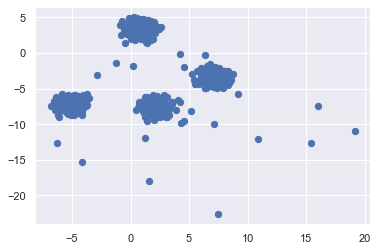

In [3]:
#plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');
plt.scatter(X[:, 0], X[:, 1], s=40, cmap='viridis');

### Project to 1-dim

Actually this is very close to KNN density estimation with

$$
    localDensity = \frac{k}{N} \frac{1}{Volume \ of d_{k} Sphere}
$$

In [4]:
nbrs = NearestNeighbors(n_neighbors=7, algorithm='ball_tree').fit(X)

In [5]:
k = 7
dist, indices = nbrs.kneighbors(X)

In [6]:
# find distance to k-th nearest neighbor
k_distances = np.array([dist[i][k - 1] for i in range(len(dist))])

In [7]:
df = pd.DataFrame(X, columns=['X','Y'])

In [8]:
df['d_k'] = k_distances

<AxesSubplot:ylabel='Density'>

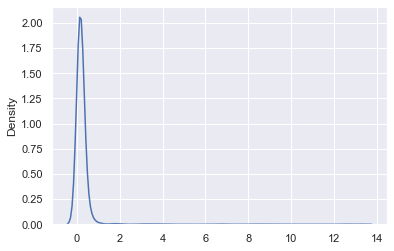

In [9]:
sns.kdeplot(k_distances)

### Boxplots

In [10]:
Q1, Q2 = np.percentile(k_distances, 0), np.percentile(k_distances, 25)
Q3, Q4 = np.percentile(k_distances, 50), np.percentile(k_distances, 75)
Q1, Q2, Q3, Q4

(0.05577668301628839,
 0.11762088514595992,
 0.1513682288905836,
 0.22448413527095057)

In [11]:
c1 = c2 = 1.5

LE = Q1 - c1 * (Q2 - Q1)
UE = Q3 + c2 * (Q3 - Q2)

### Apply a convolution like scheme

#### Schema 2

Use a Gaussian like kernel (N = dimension)

$$
    f_i(x) = \frac{\zeta_i^N}{\pi} \exp^{- \frac{(x-x_i)^2}{\zeta^N}}
$$
    
    and sort of a variable bandwidth estimator
    using the KNN results as local density approximation
    
$$       
    \zeta_i = \frac{\gamma}{(1 + d_i)^N}
$$
    Then define
$$
    Z(x) = \sum_i f_i(x)  \approx \int_{I} f_i(x) dI
$$
    and use a normalizer
$$
    T = \alpha \max_{i}(Z(x_i))
$$

For a reference the following wikipedia article about [Variable KDE](https://en.wikipedia.org/wiki/Variable_kernel_density_estimation) is a good starting point, but it doesn't cover the usage of KNN approximation to the local density as input for ballooning.

In [70]:
# Hyperparms
gamma = 1.1
alpha = 0.1
N = 2  # dimension

zeta_ = []
zett = np.zeros_like(k_distances)
for idx, d_k in np.ndenumerate(k_distances):
    zeta_i = gamma/(1 + d_k)**N
    zeta_.append(zeta_i)
    # offset variance 
    zett += zeta_i**4 * sp.stats.multivariate_normal.pdf(X, mean=X[idx,:].reshape(-1,), cov=zeta_i)
zeta = np.array(zeta_)

T = alpha * max(zett)

In [71]:
T

2.4990998218666007

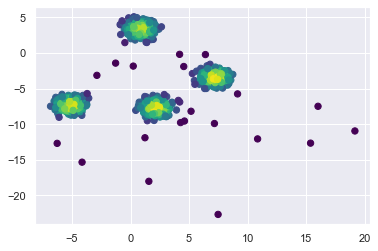

In [72]:
plt.scatter(X[:, 0], X[:, 1], c=zett, s=40, cmap='viridis')

Text(0.5, 1.0, 'Show the outliers')

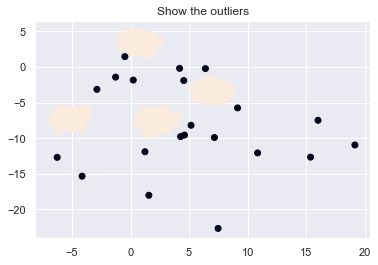

In [73]:
plt.scatter(X[:, 0], X[:, 1], c=(zett > T))
plt.title('Show the outliers')

### Simple brute force

In [16]:
gmm_model = Pipeline([('scale', MinMaxScaler()),
                      ('gmm', BayesianGaussianMixture(n_components=1, verbose=1, n_init=5,
                              init_params='random', weight_concentration_prior_type='dirichlet_distribution',
                              covariance_type='full')) ])


In [17]:
gmm_model.fit(df['d_k'].values.reshape(-1,1))

Initialization 0
Initialization converged: True
Initialization 1
Initialization converged: True
Initialization 2
Initialization converged: True
Initialization 3
Initialization converged: True
Initialization 4
Initialization converged: True


Pipeline(steps=[('scale', MinMaxScaler()),
                ('gmm',
                 BayesianGaussianMixture(init_params='random', n_init=5,
                                         verbose=1,
                                         weight_concentration_prior_type='dirichlet_distribution'))])

In [18]:
predictions = gmm_model.score_samples(df['d_k'].values.reshape(-1,1))
df['d_pred'] = -predictions

In [19]:
# We know the outliers are at the end of the array

In [20]:
-predictions[1501:1530]

array([-1.98397402e+00,  1.64390371e+02,  6.74887418e+01,  3.74872110e+01,
        1.06560771e+01,  4.89504157e+00,  9.37518890e+00,  5.48186503e-01,
       -2.71612986e-01, -1.40747905e+00, -1.99807388e+00, -1.89352246e+00,
       -1.21000465e+00,  1.48428934e+02, -1.99760048e+00,  1.32654429e+00,
        1.33734056e+01,  6.38288776e+00,  6.92326389e+00, -1.25735050e+00,
       -1.75450170e+00,  1.31871917e+01,  2.42714110e-02,  1.57309073e-01,
       -1.67633467e+00,  6.10872630e+01, -1.98155429e+00,  6.74271569e-01,
        4.12859491e+01])

<AxesSubplot:>

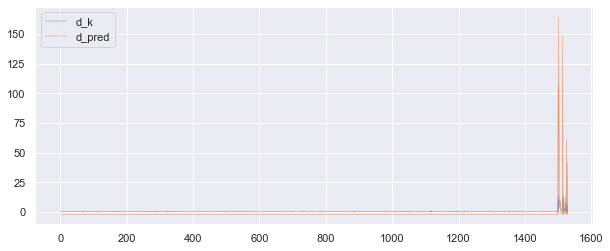

In [21]:
df[['d_k','d_pred']].plot(figsize=(10,4),lw=0.4)

Text(0.5, 1.0, 'Show the outliers')

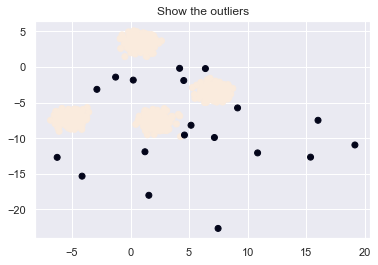

In [22]:
plt.scatter(X[:, 0], X[:, 1], c=(-predictions<0))
plt.title('Show the outliers')